In [1]:
### Ignore warnings and test if some gpu is available
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf
tf.test.is_gpu_available()

True

In [2]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [3]:
class Agent():
    def __init__(self, input_shape, n_actions, mem_size, eps, eps_min, eps_dec, gamma, q_eval_name, q_next_name, 
                 replace_freq, lr=0.0001):
        self.Q_eval = self._build_NN(input_shape, n_actions, lr)
        self.Q_next = self._build_NN(input_shape, n_actions, lr)
        self.memory = deque(maxlen=mem_size)
        self.eps = eps
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.gamma = gamma
        self.replace = replace_freq
        self.action_space = [i for i in range(n_actions)]
        self.steps = 0
        self.input_shape = input_shape
        self.q_eval_name = q_eval_name
        self.q_next_name = q_next_name
    
    def _build_NN(self, input_shape, n_actions, lr):
        
        model = Sequential()
        
        model.add(Dense(32, input_shape=(*input_shape,), activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(n_actions, activation='linear'))
        
        model.compile(optimizer=Adam(lr=lr), loss='mse')
        
        model.summary()
        
        return model
    
    def store(self, state, action, reward, n_state, done):
        pack = [np.expand_dims(state, axis=0), action, reward, np.expand_dims(n_state, axis=0), done]
        self.memory.append(pack)
    
    def take_data(self, batch_size):
        pack = random.sample(self.memory, batch_size)
        states = []
        actions = []
        rewards = []
        n_states = []
        dones = []
        for i in range(batch_size):
            states.append(pack[i][0])
            actions.append(pack[i][1])
            rewards.append(pack[i][2])
            n_states.append(pack[i][3])
            dones.append(pack[i][4])
        return states, actions, rewards, n_states, dones
    
    def choose_action(self, state):
        if np.random.random() > self.eps:
            return np.argmax(self.Q_next.predict(state))
        else:
            return np.random.choice(self.action_space)
    
    def decay_eps(self): 
        self.eps = self.eps - self.eps_dec if self.eps > self.eps_min else self.eps_min
    
    def replace_weights(self):
        if not (self.steps % self.replace):
            self.Q_next.set_weights(self.Q_eval.get_weights())
    
    def upgrade(self, batch_size=128):
        if len(self.memory) >= batch_size:
            
            states, actions, rewards, n_states, dones = self.take_data(batch_size)
            
            q_next = [np.amax(self.Q_next.predict(n_states[i])[0]) for i in range(batch_size)]
            y = [self.Q_eval.predict(states[i])[0] for i in range(batch_size)]
            
            for i in range(batch_size):
                y[i][actions[i]] = rewards[i] + self.gamma*q_next[i]*dones[i]
            
            states = np.reshape(states, (batch_size, *self.input_shape))
            self.Q_eval.fit(np.array(states), np.array(y), epochs=1, verbose=0, batch_size=batch_size)
            
            self.decay_eps()
            self.replace_weights()
    
    def save(self):
        self.Q_eval.save(self.q_eval_name)
        self.Q_next.save(self.q_next_name)

In [4]:
env = gym.make('CartPole-v1')
n_games = 1000
agent = Agent(input_shape=env.observation_space.shape, n_actions=env.action_space.n, mem_size=10000, eps=1.0, 
              eps_min=0.001, eps_dec=0.001, gamma=1.0, q_eval_name='Q_eval.h5', q_next_name='Q_next.h5', 
              replace_freq=1000)
best_score = -1000
scores = []
means = []
eps = []
for i in range(n_games):
    done = False
    state = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(np.expand_dims(state, axis=0))
        n_state, reward, done, _ = env.step(action)
        if done:
            reward -= 50
        score += reward
        agent.steps += 1
        agent.store(state, action, reward, n_state, (1 - int(done)))
        state = n_state
        agent.upgrade()
    scores.append(score)
    mean = np.mean(scores[-20:])
    means.append(mean)
    eps.append(agent.eps)
    if mean > best_score:
        agent.save()
        best_score = mean
    print('episode: ', i+1, '   score: ', int(score), '   eps:  %.3f' %agent.eps)
    if np.mean(scores[-100:]) > 195:
        print("Environment Solved!")
        agent.save()
        break
env.close()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_4 (Dense)  

episode:  149    score:  17    eps:  0.001
episode:  150    score:  51    eps:  0.001
episode:  151    score:  6    eps:  0.001
episode:  152    score:  54    eps:  0.001
episode:  153    score:  450    eps:  0.001
episode:  154    score:  450    eps:  0.001
episode:  155    score:  70    eps:  0.001
episode:  156    score:  450    eps:  0.001
episode:  157    score:  450    eps:  0.001
episode:  158    score:  9    eps:  0.001
episode:  159    score:  28    eps:  0.001
episode:  160    score:  24    eps:  0.001
episode:  161    score:  28    eps:  0.001
episode:  162    score:  110    eps:  0.001
episode:  163    score:  39    eps:  0.001
episode:  164    score:  450    eps:  0.001
episode:  165    score:  450    eps:  0.001
episode:  166    score:  15    eps:  0.001
episode:  167    score:  40    eps:  0.001
episode:  168    score:  450    eps:  0.001
episode:  169    score:  8    eps:  0.001
episode:  170    score:  450    eps:  0.001
episode:  171    score:  450    eps:  0.001
epis

KeyboardInterrupt: 

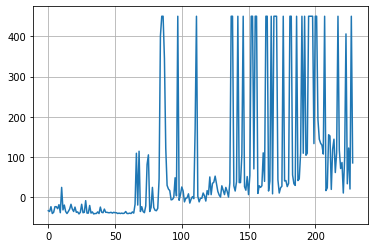

In [5]:
plt.plot(scores)
plt.grid()
plt.show()

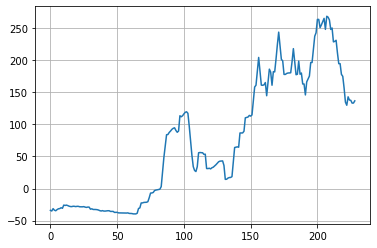

In [6]:
plt.plot(means)
plt.grid()
plt.show()

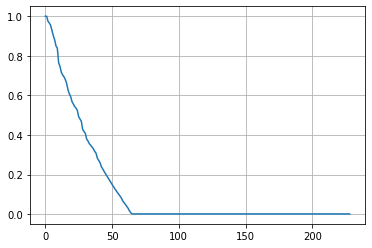

In [7]:
plt.plot(eps)
plt.grid()
plt.show()

In [ ]:
Q = load_model('Q_next.h5')
env = gym.make('CartPole-v1')
for i in range(20):
    done = False
    state = env.reset()
    while not done:
        env.render()
        action = np.argmax(Q.predict(np.expand_dims(state, axis=0))[0])
        n_state, reward, done, _ = env.step(action)
        state = n_state
env.close()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
